# Ship detection based on YOLOv3
------
## Overview
* This is the entry project of the Xilinx Adaptive Computing Challenge 2021. It uses YOLOv3 for ship target detection in optical remote sensing images, and deploys DPU on the KV260 platform to achieve hardware acceleration.

## References
* [Vitis AI Github Repository](https://github.com/Xilinx/Vitis-AI).
* [Vitis AI Tutorial](https://github.com/Xilinx/Vitis-AI-Tutorials).
* [Kria PYNQ Github Repository](https://github.com/Xilinx/Kria-PYNQ).
* [AlexeyAB Darknet](https://github.com/AlexeyAB/darknet).

------


## 1. Prepare the overlay
Download the overlay onto the board.

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

## 2. Utility functions
Prepare funtions for preprocess and evaluate. To use *matplotlib widget*, It is necessary to install the jupyter-matplotlib plugin in JupyterLab. Otherwise, replace `%matplotlib widget` with `%matplotlib inline`.

**Note**: For the KV260 board you may see TLS memory allocation errors if cv2 gets loaded before loading the vitis libraries in the Jupyter Lab environment. Make sure to load cv2 first in these cases.

In [2]:
import os
import time
import cv2
import time
import numpy as np
import random

import colorsys
from time import time

from self_def.yolov3_voc import *
%matplotlib widget

The `load_model()` method will automatically prepare the `graph`
which is used by VART.

In [3]:
overlay.load_model("ship_detection.xmodel")

Prepare anchor boxes and class lists for postprocessing.

In [4]:
anchor_list = [10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326]

# anchor_list = [20,23,53,34,26,88,136,34,91,91,51,116,186,80,105,203,199,173]
anchor_float = [float(x) for x in anchor_list]
anchors = np.array(anchor_float).reshape(-1, 2)

class_names = ["ship"]

Generate a set of colors for different categories, so that each category's prediction box is labeled with a different color.

In [5]:
num_classes = len(class_names)
hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: 
                  (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), 
                  colors))
random.seed(0)
random.shuffle(colors)
random.seed(None)

Read the test image from the directory and draw it. The test images should be placed under the `ship_data` folder in the same directory as the notebook.

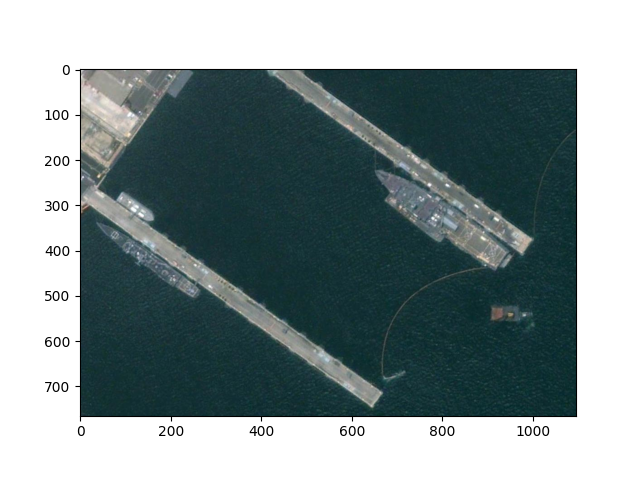

In [6]:
cv_image = []
image_size = []
image_data = []

image_folder = 'ship_data'
original_images = [i for i in os.listdir(image_folder) if i.endswith("jpg")]
total_images = len(original_images)



for image in original_images:  
    cv_image.append(cv2.imread(os.path.join(image_folder, image)))
    image_size.append(cv_image[-1].shape[:2])
    
index = 6
    
_, ax = plt.subplots(1)
_ = ax.imshow(cv2.cvtColor(cv_image[index], cv2.COLOR_BGR2RGB))

## 3. Use VART
Use VART to do object detection. The code below define a few buffers to store input and output data. They will be reused during multiple runs.

In [7]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outTen.dims for outTen in outputTensors)

outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

output_data = [np.empty(shape, dtype=np.float32, order="C") for shape in shapeOut]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]

Define a new function `run()` which takes image tensor as the input, and calculate output tensor in DPU. The input tensor is obtained from the preprocessed image and has a size of 416x416x3. The preprocess fuction is imported from `self_def.yolov3_voc`.

In [8]:
def run(image):
    input_data[0] = np.array(pre_process(image, (416, 416)), dtype=np.float32);
    job_id = dpu.execute_async(input_data, output_data);
    dpu.wait(job_id)

    return output_data

Run YOLOv3 on DPU for multiple images.

In [9]:
%%capture
start = time()
[run(image) for image in cv_image];
stop = time()

Calculate Execution time and FPS for model.

In [10]:
execution_time = stop - start 
print(" Execution time : {:.6f}s".format(execution_time))

fps = total_images/execution_time
print("Performance: {:.6f} FPS".format(fps))

 Execution time : 1.571209s
Performance: 7.637429 FPS


Postprocessing for the output vector, including candidate box generation, NMS suppression and confidence calculation. The resulting data is used to draw the prediction box.

0.3795620437956204
416
290


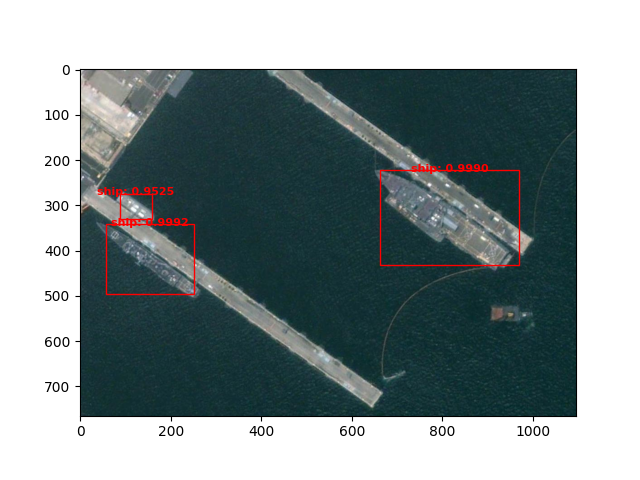

In [11]:
index = 6

output_data = run(cv_image[index])

boxes, scores, classes = evaluate(output_data, image_size[index], class_names, anchors);
_ = draw_boxes(cv_image[index], boxes, scores, classes, class_names, colors);

Remove references to `vart.Runner` and let Python garbage-collect the unused graph objects.

In [12]:
del overlay
del dpu

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----